# Model Training

In [241]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import cv2

## Download traning data

In [242]:
zip = tf.keras.utils.get_file('data.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://drive.google.com/uc?export=download&id=1kMc_A-I8jUf8P5vqanvCjmjdfail5uMP',
                                          extract = True)
os.remove(zip)

data_dir='./data'

1187840/Unknown - 0s 0us/step

## Set data parameters

In [243]:
batch_size = 64
img_height = 100
img_width = 100
validation_split = 0.2

## Data preprocessing

### Traning data

In [244]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=888,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2423 files belonging to 2 classes.
Using 1939 files for training.


### Validation data

In [245]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=888,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2423 files belonging to 2 classes.
Using 484 files for validation.


## Class labels

In [246]:
class_names = train_ds.class_names
print(class_names)

['ClosedFace', 'OpenFace']


## Show traing data

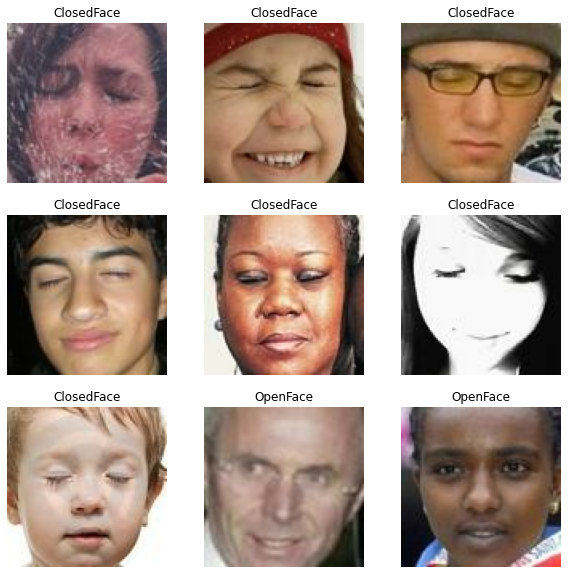

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Show training data array and label shape

In [248]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 100, 100, 3)
(64,)


## Data prefetch

In [249]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augumentation (solve overfitting)

In [250]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Data augumentaion show

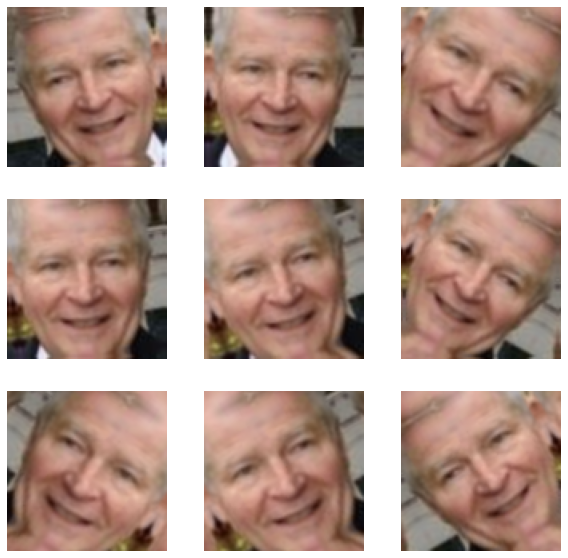

In [251]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model

In [252]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 25, 25, 64)      

## Set optimizer, loss function

In [253]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training

In [254]:
epochs=150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/150
31/31 [==============================] - 2s 39ms/step - loss: 0.6967 - accuracy: 0.5101 - val_loss: 0.6955 - val_accuracy: 0.5062
Epoch 2/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6923 - accuracy: 0.5252 - val_loss: 0.6637 - val_accuracy: 0.6012
Epoch 3/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6538 - accuracy: 0.6139 - val_loss: 0.6512 - val_accuracy: 0.6384
Epoch 4/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6699 - accuracy: 0.5924 - val_loss: 0.6122 - val_accuracy: 0.6694
Epoch 5/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6390 - accuracy: 0.6466 - val_loss: 0.6655 - val_accuracy: 0.6033
Epoch 6/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6467 - accuracy: 0.6413 - val_loss: 0.6426 - val_accuracy: 0.6384
Epoch 7/150
31/31 [==============================] - 1s 20ms/step - loss: 0.6585 - accuracy: 0.6166 - val_loss: 0.5894 - val_accuracy: 0.6942
Epoch 

## Accuracy and loss plot

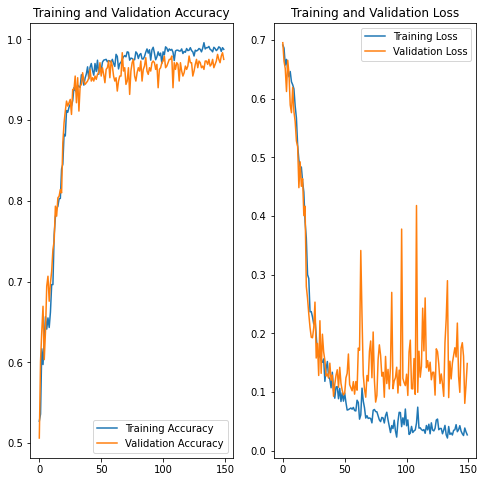

In [255]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Video process

## Download video

In [256]:
tf.keras.utils.get_file('video_testvar.mp4',
                        cache_subdir=os.path.abspath('.'), origin = 'https://drive.google.com/uc?export=download&id=1ENlG1_mY4sWIztvmpcmuDVBH_GrqTHaT')
                        #origin = 'https://drive.google.com/uc?export=download&id=10sAjr23sx0hi85Ph51ysNA3-XmJopa2O')

450560/444055 [==============================] - 0s 0us/step


'/content/video_testvar.mp4'

## Set openCV cascade classifier for face

In [257]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')



## Load video and get information of it

In [258]:
cap = cv2.VideoCapture('./video_testvar.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Video FPS:", fps)
print("Number of frames: ", int(num_frames))
count = 0
img_array = []
close_frame = 0.0

Video FPS: 15.121255349500712
Number of frames:  53


## Video processing

In [259]:
while (cap.isOpened()):
  ret, frame = cap.read()
  if ret == False:
    break
  frame = cv2.resize(frame,
                    (640, 360),
                    interpolation = cv2.INTER_AREA)
  #frame=cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  frame_gray = cv2.equalizeHist(frame_gray)
  height,width = frame.shape[:2]
  faces = face_cascade.detectMultiScale(frame_gray, minSize=(img_height,
                                                            img_width))
  label = 'No face detected'
  color = (255,0,0)

  for (x,y,w,h) in faces:
    center = (x + w//2, y + h//2)
    faceROI = frame[y:y+h, x:x+w, :]
    img = cv2.resize(faceROI,
                    (img_height, img_width),
                    interpolation = cv2.INTER_AREA)
    img = tf.expand_dims(img, 0)
    predictions = model.predict(img)
    score = tf.nn.softmax(predictions[0])
    label = class_names[np.argmax(score)]

  if label == 'ClosedFace':
    close_frame += 1.0
  else:
    close_frame = 0.0
  
  close_time = close_frame / fps

  if close_time < 0.5:
    label = 'You are awake'
    color = (0,255,0)
  elif close_time < 1:
    label = 'Warning! t=' + str('%.3f'%(close_time))
    color = (0,255,255)
  else:
    label = 'Wake Up! t=' + str('%.3f'%(close_time))
    color = (0,0,255)

  cv2.putText(frame, label, (0, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
  img_array.append(frame) 
  count+=1
cap.release()

## Save the video

In [260]:
out = cv2.VideoWriter('result.avi',
                      cv2.VideoWriter_fourcc(*'DIVX'),
                      fps,
                      (width,height))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
cv2.destroyAllWindows()